In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import numpy as np
import cmath
import matplotlib.pyplot as plt
import h5py

print(os.getpid())
%cd ../../

colors_ = ["blue", "red", "green", "gray", "black"]

import pylib.mix as mix
import pylib.measurement as mse

26551
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(30):
    plt.close()

In [15]:
# ------------------------------------------------------------------
# --- Create a test matrix ---
# ------------------------------------------------------------------
from numpy import linalg as LA

# --- Original matrix ---
n_ = 10
N = 1 << n_
x = np.linspace(-1.0, 1.0, N)
y = np.sin(x)
A_orig = np.diag(y)

# --- Normalized matrix ---
nonsparsity = 1  
rows_sum = np.zeros(N)
for ir in range(N):
    rows_sum[ir] = np.sqrt(np.sum(np.abs(A_orig[ir,:])**2))
coef_norm_H = np.max(rows_sum)

final_norm_of_H_ = nonsparsity
if coef_norm_H > 1:
    final_norm_of_H_ *= coef_norm_H
    
A = A_orig/final_norm_of_H_
print("\nNormalization factor: {:0.3e}".format(final_norm_of_H_))

# --- Condition number ---
evals, evecs = LA.eig(A)
kappa_ = np.max(np.abs(evals)) / np.min(np.abs(evals))
print("cond. number: {:0.1f}".format(kappa_))
print()

# --- SIN parameters ---
alpha_k0 = - 1.0
alpha_k1 = np.abs(alpha_k0) * N/(N - 1)
print("   nx \t{:d}".format(n_))
print("   alpha_k0 \t{:0.12e}".format(alpha_k0))
print("   alpha_k1 \t{:0.12e}".format(alpha_k1))


Normalization factor: 1.000e+00
cond. number: 860.8

   nx 	10
   alpha_k0 	-1.000000000000e+00
   alpha_k1 	1.000977517107e+00


Reading the file ./examples/matrix-inversion-sin//MI_OUTPUT.hdf5...
Name of the simulation is MI
Simulation has been performed  01-22-2024 13:44:55

max. abs. err: 8.350e-01
sim. kappa: 860.8
QSVT kappa: 900.0


<IPython.core.display.Javascript object>


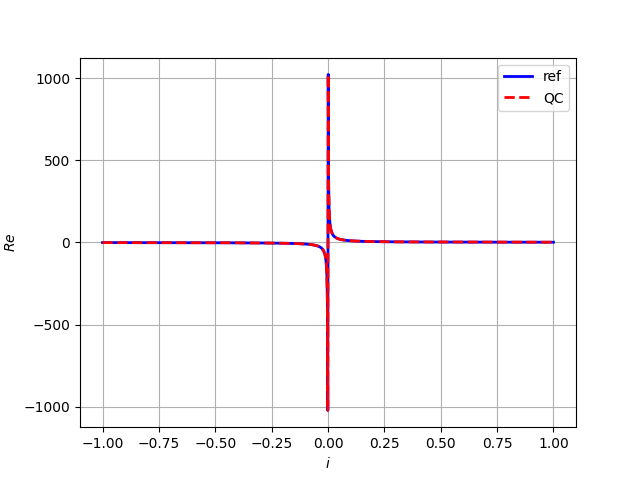

In [16]:
# -------------------------------------------------
# --- Matrix inversion ---
# -------------------------------------------------
mix.reload_module(mse)

# --- Reading QC data ---
path_data_ = "./examples/matrix-inversion-sin/"
pr_name_ = "MI"

om = mse.MeasOracle__(True)
om.path_  = path_data_
om.pname_ = pr_name_
om.open()
om.set_zero_ancillae_work_states(0)
qc_data = om.get_var_x({}, "rs")

# --- reference data ---

ref_data = 1./y
# ref_data = y

# --- QuCF data ---
# qc_data = -qc_data.real
# qc_data *= 2**(n_/2.)

om.read_qsvt()
qc_data = qc_data.imag
kappa_qc = om.dd_["qsvt_mi"]["par"]
qc_data *= 2**(n_/2.) * kappa_qc * om.dd_["qsvt_mi"]["rescaling_factor"]
# qc_data /= np.sqrt( np.sum( np.abs(qc_data)**2 ) )

# --- Maximum absolute error ---
max_abs_err = np.max(np.abs(ref_data - qc_data))
print()
print("max. abs. err: {:0.3e}".format(max_abs_err))
print("sim. kappa: {:0.1f}".format(kappa_))
print("QSVT kappa: {:0.1f}".format(kappa_qc))


# --- Plotting ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(
    x, ref_data.real, 
    color='b', linewidth = 2, linestyle='-',  
    label = "ref"
)
ax.plot(
    x, qc_data,
    color='r', linewidth = 2, linestyle='--',  
    label = "QC"
)
plt.xlabel('$i$')
plt.ylabel("$Re$")
ax.legend()
plt.grid(True)
plt.show()